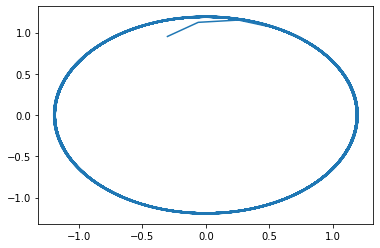

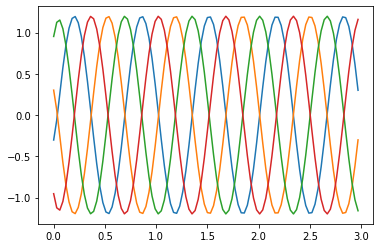

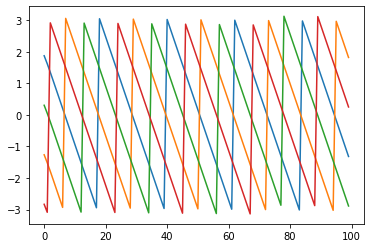

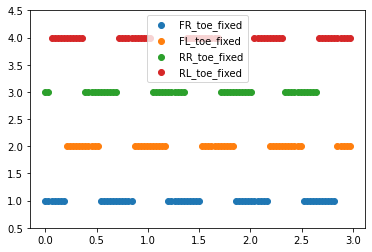

In [10]:
import numpy as np
from blind_walking.envs.utilities.cpg import CPGSystem, CPGParameters

params = CPGParameters(
    a=1.0,
    b=50.0,
    mu=1.0,
    alpha=10.0,
    beta=0.5,
    gamma=50.0,
    period=1 / 1.5,
    dt=0.030,  # 0.03 seconds = 0.001 sim_time_step * 30 action_repeat
)

phase_offsets = {
    "walk": np.array([3 * np.pi / 2, np.pi / 2, np.pi, 0]),
    "trot": np.array([np.pi, 0, 0, np.pi]),
    "pace": np.array([np.pi, 0, np.pi, 0]),
    "bound": np.array([np.pi, np.pi, 0, 0]),
}

foot_contact_fn = {
    "walk": lambda phase: 2 * (phase > 0).astype(int) - 1,
    "trot": lambda phase: 2 * (phase > 0).astype(int) - 1,
    "pace": lambda phase: 2 * (phase > 0).astype(int) - 1,
    "bound": lambda phase: 2 * (phase > 0).astype(int) - 1,
}

cpg_system = CPGSystem(
    params=params,
    coupling_strength=1,
    desired_phase_offsets=phase_offsets['walk'],
    initial_state=CPGSystem.sample_initial_state(phase_offsets['walk']),
)

state_history = np.zeros((1000, 4, 2))
phase_history = np.zeros((1000, 4))
foot_contacts = np.zeros((1000, 4))
for i in range(1000):
    state_history[i] = cpg_system.get_state()
    phase_history[i] = cpg_system.get_phase()
    foot_contacts[i] = foot_contact_fn['walk'](phase_history[i])
    cpg_system.step()

foot_names = ['FR_toe_fixed', 'FL_toe_fixed', 'RR_toe_fixed', 'RL_toe_fixed']
time = np.arange(1000) * 0.03

import matplotlib.pyplot as plt
plt.plot(state_history[:,0,0], state_history[:,0,1])
plt.figure()
for i in range(4):    
    plt.plot(time[:100], state_history[:100, i, 0], label = foot_names[i])

plt.figure()
plt.plot(np.arange(100), phase_history[:100])


plt.figure()
plt.ylim(0.5, 4.5)
for i in range(4):    
    plt.scatter(time[:100], foot_contacts[:100, i] * (i+1), label = foot_names[i])
plt.legend()
